# Please Note:

This code was developed by working through documentation in GluonTS. I read the docuemnts and ported the code to Colab before switching the dataset and beginning to tweak and adjust for our own needs. Many of the text I have also taken from the docs so that I can remember what lines do without going back and forth. The final version will include all proper citation

In [4]:
# Install Dependencies
!pip install gluonts
!pip install mxnet
!pip install pytorch-lightning
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [6]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os

dataset = pd.read_csv('/content/drive/Shareddrives/Neural Networks Final Project/ignition_data_ts.csv',index_col=0,parse_dates=True,header=0) # Read CSV
dataset.head() #2190 rows

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,n_fires,log_n_fires
REP_DATE,,
1979-12-30,5,1.791759
1980-01-06,0,0.000000
1980-01-13,1,0.693147
1980-01-20,1,0.693147
1980-01-27,3,1.386294


In [7]:
# Declare constant group column 
from gluonts.dataset.pandas import PandasDataset

# The code below works so the next step is to add a train test split

# Take the first 1750 rows (1979-12-30 to 2013-07-14) for training (roughly 75%) 
train_df = dataset[:1750]

# Take the rest of the rows for testing (2013-07-14 to 2021-12-14)
test_df = dataset[1750:]

# Create Training and Test Sets using the PandasDataset class
train_ds = PandasDataset(train_df, freq='1W', target='log_n_fires')
test_ds = PandasDataset(test_df, freq='1W', target='log_n_fires')

This is what the data looks like

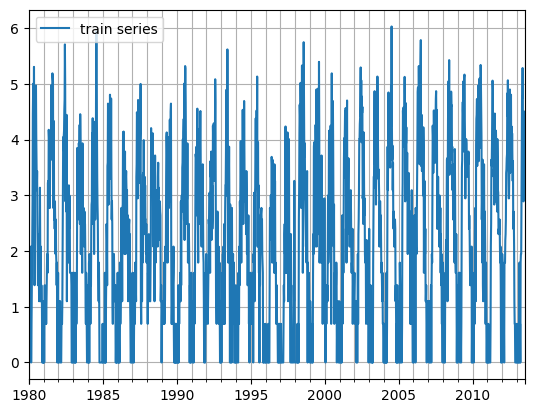

In [8]:
to_pandas(next(iter(train_ds))).plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

fourier transform

In [9]:
import optuna
import torch
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.torch.model.deepar import DeepAREstimator

# From GluonTS Docs:

We will now tune the DeepAR estimator on our training data using Optuna. We choose two hyperparameters num_layers and hidden_size to optimize.

First, we define a dataentry_to_dataframe method to transform a DataEntry into a pandas.DataFrame. Second, we define an DeepARTuningObjective class used in tuning process of Optuna. The class can be configured with the dataset, prediction length and data frequency, and the metric to be used for evaluating the model. In the __init__ method, we initialize the objective and split the dataset using split method existed in our GluonTS project. - validation_input: the input part used in validation - validation_label: the label part used in validation In the get_params method, we define what hyperparameters to be tuned within given range. In the __call__ method, we define the way the DeepAREstimator is used in training and validation.

In [10]:
def dataentry_to_dataframe(entry):
    """creates a pandas DataFrame object from a dictionary entry.

    Args:
        entry (array): contains the data values to be stored in the DataFrame

    Returns:
        df (pandas DataFrame object): a DataFrame object with the data values from entry
    """    
    # create a new DataFrame object df using the pandas DataFrame constructor pd.DataFrame()
    df = pd.DataFrame(
        # entry["target"] is a 1-dimensional array or list containing the data values to be stored in the DataFrame
        entry["target"],
        # an optional argument that specifies the column labels for the DataFrame. The get() method is used to retrieve the value associated with the key 
        # "item_id" in the entry dictionary.
        columns=[entry.get("item_id")],
        # specifies the row labels for the DataFrame. It creates a PeriodIndex with a start date of entry["start"], a length of len(entry["target"]), and a 
        # frequency equal to the frequency of entry["start"]. The resulting PeriodIndex object is used as the index for the DataFrame.
        index=pd.period_range(
            start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq
        ),
    )

    return df


class DeepARTuningObjective:
    def __init__(
        self, dataset, prediction_length, freq, metric_type="RMSE"
    ):
        # This is the input dataset for the forecasting model. It is a PandasDataset object.
        self.dataset = dataset
        # This is the length of the prediction window, which is the number of time steps that the model is trained to forecast into the future.
        self.prediction_length = prediction_length
        #  This is the frequency of the time series data
        self.freq = freq
        # the type of evaluation metric to be used for measuring the performance of the forecasting model. The default value is "mean_wQuantileLoss",
        self.metric_type = metric_type
        # self.train is a training dataset, obtained by splitting the input dataset and removing the prediction window from the end of each time series.
        # test_template is a template for the test dataset, which includes only the time series data up to the point where the prediction window starts.
        self.train, test_template = split(dataset, offset=-self.prediction_length)
        # validation: This is the validation dataset, obtained by generating instances from the test template with the same length as the prediction window.
        validation = test_template.generate_instances(
            prediction_length=prediction_length
        )
        # validation_input is the input data for the validation dataset.
        self.validation_input = [entry[0] for entry in validation]
        # validation_label: This is the label or target data for the validation dataset, which is a list of dataframes representing the true values for 
        # each time series in the validation dataset.
        self.validation_label = [
            dataentry_to_dataframe(entry[1]) for entry in validation
        ]
        # Note on why we need to use the dataentry_to_dataframe() function: The validation dataset is a list of tuples, where each tuple contains two 
        # elements. The first element is an instance of the test template, and the second element is the label or target data for the instance. The 
        # dataentry_to_dataframe() function is used to convert the second element of each tuple into a pandas DataFrame object. This is necessary because
        # the DeepAREstimator class expects the target data to be in the form of a pandas DataFrame object.
        

    def get_params(self, trial) -> dict:
        """takes a trial object as input and returns a dictionary of hyperparameters for a DeepAR forecasting model that is tuned using the Optuna library.

        Args:
            trial (optuna.trial.Trial): an Optuna trial object

        Returns:
            dict: a dictionary of hyperparameters for a DeepAR forecasting model
        """        
        return {
            "epochs": trial.suggest_int("epochs", 1, 1000),
            # context_length: This is the length of the context window, which is the number of time steps that the model uses to make a prediction. The value
            # of this hyperparameter is an integer between 3 and 100.
            "context_length": trial.suggest_int("context_length", 1,200),
            "batch_size": trial.suggest_int("batch_size", 32, 1028),
            # Learning rate (default: ``1e-3``)
            "lr": trial.suggest_float("lr", 1e-5, 1e-1),
            # aka hidden size aka num_cells
            "hidden_size": trial.suggest_int("hidden_size", 3, 200),
            # num_layers: This is the number of recurrent layers in the DeepAR forecasting model. The value of this hyperparameter is an integer between 1 and 10.
            "num_layers": trial.suggest_int("num_layers", 1, 8),
            # Dropout regularization parameter (default: 0.1)
            "dropout_rate": trial.suggest_uniform("dropout_rate", 0.00, 0.2),
            "embedding_dimension": trial.suggest_int("embedding_dimension", 1, 50)
        }

    def __call__(self, trial):
        """This is a Python callable that is used as the objective function for optimizing the hyperparameters of a DeepAR forecasting model. 
         By using this function as the objective function for an optimization library such as Optuna, the hyperparameters can be automatically 
         tuned to optimize the performance of the model on a given dataset.

        Args:
            trial (optuna.trial.Trial): an Optuna trial object

        Returns:
            agg_metrics (float): the value of the evaluation metric for the DeepAR forecasting model with the hyperparameters generated by the trial object
        """        
        #  This line generates a dictionary of hyperparameters using the get_params method, which is defined above.
        params = self.get_params(trial)
        # This line creates a DeepAR estimator object using the hyperparameters generated in the previous step, as well as some other fixed 
        # parameters (such as the prediction length, frequency, and training options).
        estimator = DeepAREstimator(
            num_layers=params["num_layers"],
            hidden_size=params["hidden_size"],
            prediction_length=self.prediction_length,
            context_length = params["context_length"],
            batch_size = params["batch_size"],
            lr = params["lr"],
            dropout_rate = params["dropout_rate"],
            embedding_dimension = [params["embedding_dimension"]],
            freq=self.freq,
            trainer_kwargs={
                "enable_progress_bar": False,
                "enable_model_summary": False,
                "max_epochs": params["epochs"],
            },
        )
        # This line trains the DeepAR forecasting model using the training dataset. The cache_data argument is set to True, which means that the training
        # dataset is cached in memory so that it can be reused for subsequent training runs.
        predictor = estimator.train(self.train, cache_data=True)
        # This line generates forecasts for the validation dataset.
        forecast_it = predictor.predict(self.validation_input)

        # This line converts the forecasts into a list.
        forecasts = list(forecast_it)

        # This line computes the evaluation metric for the validation dataset. 
        # The quantiles argument specifies the quantiles of the forecast distribution to use in the evaluation.
        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        # The evaluator() method returns two dictionaries: agg_metrics and item_metrics. The agg_metrics dictionary contains the aggregated evaluation
        # metrics for the entire validation dataset, while the item_metrics dictionary contains the evaluation metrics for each time series in the 
        # validation dataset. The evaluation metric that is used is specified by the metric_type argument, which is set to "mean_wQuantileLoss" by default.
        agg_metrics, item_metrics = evaluator(
            self.validation_label, forecasts, num_series=len(self.dataset)
        )
        # This line returns the evaluation metric for the validation dataset. This value is used as the objective function for the hyperparameter 
        # optimization algorithm, which tries to minimize it by suggesting different sets of hyperparameters in each trial.
        
        # Below was it
        # return agg_metrics[self.metric_type]
        return agg_metrics["RMSE"]

We can now invoke the Optuna tuning process.

In [ ]:
# # Do not Run so we can see output from optimizer----------------------------


# import time

# # This line uses time.time() to record the start time of the hyperparameter optimization process.
# start_time = time.time()

# # This line creates an Optuna study object for optimizing the hyperparameters of a DeepAR forecasting model. The direction argument is set to "minimize",
# # which means that the hyperparameter optimization algorithm will try to minimize the evaluation metric returned by the objective function.

# study = optuna.create_study(direction="minimize")
# # This line starts the hyperparameter optimization process. The objective argument is set to the DeepARTuningObjective class, which is defined above.
# # It uses the training dataset, a prediction length of 10, and a frequency of 1 week.
# # The n_trials argument is set to 5, which means that the hyperparameter optimization algorithm will run for 5 trials. 


# # Do not Run so we can see output from optimizer----------------------------
# study.optimize(
#     DeepARTuningObjective(
#         train_ds, 10, "1W"
#     ),
#     n_trials=5,
# )

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# # Calling the best_trial attribute of the study object returns the trial object with the best evaluation metric.
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))
# print(time.time() - start_time)

[I 2023-04-26 18:39:23,557] A new study created in memory with name: no-name-200f49e2-9a8f-4b12-bf43-b3b61b4ac1fc
<ipython-input-20-e67d6025f36c>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.00, 0.2),
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilitie

Number of finished trials: 5
Best trial:
  Value: 0.7141727516311484
  Params: 
    epochs: 181
    context_length: 61
    batch_size: 767
    lr: 0.0918584187587629
    hidden_size: 55
    num_layers: 1
    dropout_rate: 0.11223062995545004
    embedding_dimension: 37
42300.03534889221


# Re-training the model
After getting the best hyperparameters by optuna, you can set them into the DeepAR estimator to re-train the model on the whole training subset we consider here.

In [ ]:
# This line creates a DeepAR forecasting model using the hyperparameters generated by the Optuna hyperparameter optimization algorithm.
estimator = DeepAREstimator(
    num_layers=trial.params["num_layers"],
    hidden_size=trial.params["hidden_size"],
    prediction_length=10,
    context_length=trial.params["context_length"],
    lr = trial.params["lr"],
    dropout_rate = trial.params["dropout_rate"],
    embedding_dimension = [trial.params["embedding_dimension"]],
    freq="1W",
    trainer_kwargs={
        "enable_progress_bar": True,
        "enable_model_summary": True,
        "max_epochs": trial.params["epochs"],
    },
)

In [11]:
# This line creates a DeepAR forecasting model using the hyperparameters generated by the Optuna hyperparameter optimization algorithm.
estimator = DeepAREstimator(
    num_layers=1,
    hidden_size=55,
    prediction_length=10,
    context_length=61,
    batch_size = 767,
    lr = 0.0918584187587629,
    dropout_rate = 0.11223062995545004,
    embedding_dimension = [37],
    freq="1W",
    trainer_kwargs={
        "enable_progress_bar": True,
        "enable_model_summary": True,
        "max_epochs": 181,
    },
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset train_subset by invoking the train method of the estimator. The training algorithm returns a fitted model (or a Predictor in GluonTS parlance) that can be used to obtain forecasts.

In [12]:
# This line trains the DeepAR forecasting model using the training dataset. The cache_data argument is set to True, which means that the training
# dataset is cached in memory so that it can be reused for subsequent training runs.
predictor = estimator.train(train_ds, cache_data=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11223062995545004 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 2.06672 (best 2.06672), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 1.79648 (best 1.79648), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 1.79486 (best 1.79486), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 1.79481 (best 1.79481), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300

# Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the test dataset and evaluate our model’s performance.

GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

1. Removes the final window of length prediction_length of the test dataset that we want to predict

2. The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed

3. The forecasts are returned, together with ground truth values for the same time range (as python generator objects)


In [13]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
)

# GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:
#     Removes the final window of length prediction_length of the dataset.test that we want to predict
#     The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed
#     The module outputs the forecast sample paths and the dataset.test (as python generator objects)


In [1]:
import pandas as pd

# Create a date range for the year 2022
date_range = pd.date_range(start='2022-01-01', end='2022-12-31', freq='W-SUN')

# Create a Pandas Series object with the date range as the index
weekly_series = pd.Series(index=date_range)

# Print the resulting Series
print(weekly_series)

2022-01-02   NaN
2022-01-09   NaN
2022-01-16   NaN
2022-01-23   NaN
2022-01-30   NaN
2022-02-06   NaN
2022-02-13   NaN
2022-02-20   NaN
2022-02-27   NaN
2022-03-06   NaN
2022-03-13   NaN
2022-03-20   NaN
2022-03-27   NaN
2022-04-03   NaN
2022-04-10   NaN
2022-04-17   NaN
2022-04-24   NaN
2022-05-01   NaN
2022-05-08   NaN
2022-05-15   NaN
2022-05-22   NaN
2022-05-29   NaN
2022-06-05   NaN
2022-06-12   NaN
2022-06-19   NaN
2022-06-26   NaN
2022-07-03   NaN
2022-07-10   NaN
2022-07-17   NaN
2022-07-24   NaN
2022-07-31   NaN
2022-08-07   NaN
2022-08-14   NaN
2022-08-21   NaN
2022-08-28   NaN
2022-09-04   NaN
2022-09-11   NaN
2022-09-18   NaN
2022-09-25   NaN
2022-10-02   NaN
2022-10-09   NaN
2022-10-16   NaN
2022-10-23   NaN
2022-10-30   NaN
2022-11-06   NaN
2022-11-13   NaN
2022-11-20   NaN
2022-11-27   NaN
2022-12-04   NaN
2022-12-11   NaN
2022-12-18   NaN
2022-12-25   NaN
Freq: W-SUN, dtype: float64


<ipython-input-1-4793609e679a>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weekly_series = pd.Series(index=date_range)


First, we can convert these generators to lists to ease the subsequent computations.

In [14]:
# This line converts the forecasts into a list.
forecasts = list(forecast_it)
# This line converts the test iteration into a list.
tss = list(ts_it)

Forecast objects have a plot method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a “fan chart”.

In [15]:
def plot_prob_forecasts(ts_entry, forecast_entry):
      """Plot the time series and the forecasted probability distribution.

    Args:
        ts_entry (pandas.Series): test time series
        forecast_entry (numpy.ndarray): forecast sample paths
    """  
    
      # Set the variable that determines how many data points to show in the plot.
      plot_length = 150
      # prediction intervals is a tuple containing the prediction intervals to be plotted.
      prediction_intervals = (50.0, 90.0)
      # Define legend, a list of strings that contains the labels for the legend of the plot
      # Shown in the format: [observations, median prediction, 90% prediction interval, 50% prediction interval]
      legend = ["observations", "median prediction"] + [
          f"{k}% prediction interval" for k in prediction_intervals
      ][::-1]
      # Creates a new figure with one subplot with the specified size
      fig, ax = plt.subplots(1, 1, figsize=(10, 7))
      # Plots the last plot_length data points of the time series on the subplot
      ts_entry[-plot_length:].plot(ax=ax)
      # plots the probabilistic forecast with the specified prediction intervals in green color
      forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
      # Adds grid lines to the plot
      plt.grid(which="both")
      # Adds a legend to the plot
      plt.legend(legend, loc="upper left")
      # Limit the y-axis to be between 0 and 10
      plt.ylim([0, 10])
      # Displays the plot
      plt.show()

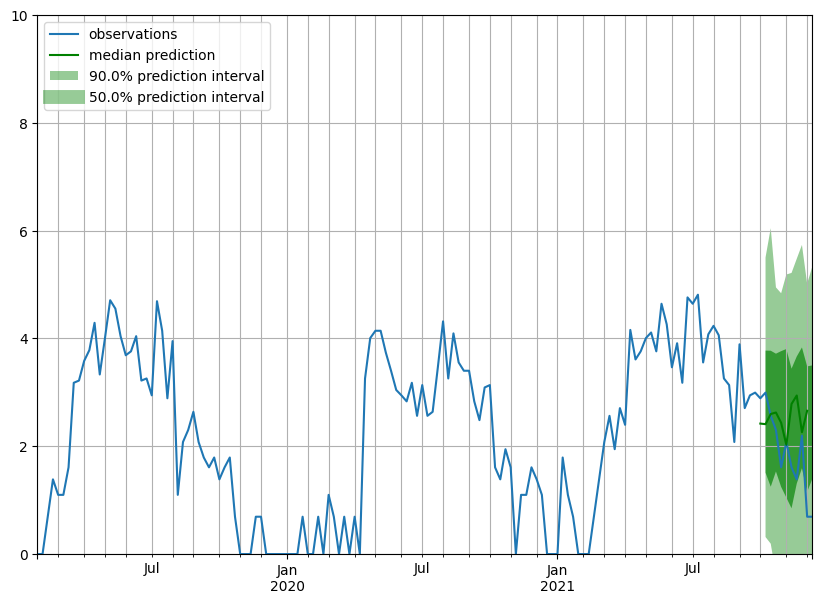

In [16]:
plot_prob_forecasts(tss[0], forecasts[0])

We can also evaluate the quality of our forecasts numerically. In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [17]:
from gluonts.evaluation import Evaluator
# The Evaluator class computes aggregate performance metrics for probabilistic forecasts.  For probabilistic forecasts, 
# it evaluates the predicted quantiles and prediction intervals at different levels, specified by the quantiles parameter.

# Create an instance of the Evaluator class with the quantiles parameter set to [0.1, 0.5, 0.9].
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# Computes evaluation metrics for each time series in tss and its corresponding forecast object in forecasts and returns two dictionaries:
# agg_metrics and item_metrics. The agg_metrics dictionary contains the aggregated evaluation metrics for the entire validation dataset, while the 
# item_metrics dictionary contains the evaluation metrics for each time series in the validation dataset. The evaluation metric that is used is specified 
# by the metric_type argument, which is set to "mean_wQuantileLoss" by default.
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 1it [00:00, 32.05it/s]


In [18]:
# This line prints the aggregated evaluation metrics for the entire validation dataset.
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.8751604885068739,
    "abs_error": 8.494264082041482,
    "abs_target_sum": 18.131397390133618,
    "abs_target_mean": 1.8131397390133617,
    "seasonal_error": 0.5973869519845737,
    "MASE": 1.4219031824887982,
    "MAPE": 0.7889839786182653,
    "sMAPE": 0.44578811770423615,
    "MSIS": 11.968317658528923,
    "QuantileLoss[0.1]": 3.082388595743275,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 8.494264082041482,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 5.877543039368294,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.9355001274756054,
    "NRMSE": 0.5159558898558294,
    "ND": 0.4684836970515974,
    "wQuantileLoss[0.1]": 0.17000281497445904,
    "wQuantileLoss[0.5]": 0.4684836970515974,
    "wQuantileLoss[0.9]": 0.3241638199693653,
    "mean_absolute_QuantileLoss": 5.818065239051017,
    "mean_wQuantileLoss": 0.3208834439984739,
    "MAE_Coverage": 0.5,
    "OWA": NaN
}


In [39]:
dataset = pd.read_csv('/content/drive/Shareddrives/Neural Networks Final Project/ignition_data_bins_ts.csv',index_col=0,parse_dates=True,header=0) # Read CSV
dataset.head() #2190 rows

,lat_long_bin_1,lat_long_bin_2,lat_long_bin_3,lat_long_bin_4,lat_long_bin_5,lat_long_bin_6,lat_long_bin_7,lat_long_bin_8,lat_long_bin_9,lat_long_bin_10,lat_long_bin_11,lat_long_bin_12,lat_long_bin_13,lat_long_bin_14,lat_long_bin_15,lat_long_bin_16
REP_DATE,,,,,,,,,,,,,,,,
1979-12-30,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147,1.098612,0.000000,0.693147,0.0,0.000000
1980-01-06,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1980-01-13,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.000000
1980-01-20,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000
1980-01-27,0.0,0.0,0.693147,0.0,0.0,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.693147


In [40]:
# Declare constant group column 
from gluonts.dataset.pandas import PandasDataset

# The code below works so the next step is to add a train test split

# Take the first 1750 rows for training (roughly 75%)
train_df = dataset[:1750]

# Take the rest of the rows for testing
test_df = dataset[1750:]

In [43]:
test_df.head()

,lat_long_bin_1,lat_long_bin_2,lat_long_bin_3,lat_long_bin_4,lat_long_bin_5,lat_long_bin_6,lat_long_bin_7,lat_long_bin_8,lat_long_bin_9,lat_long_bin_10,lat_long_bin_11,lat_long_bin_12,lat_long_bin_13,lat_long_bin_14,lat_long_bin_15,lat_long_bin_16
REP_DATE,,,,,,,,,,,,,,,,
2013-07-14,0.000000,1.945910,1.945910,0.0,0.000000,1.098612,0.000000,0.0,1.945910,1.386294,1.098612,0.000000,0.693147,1.791759,0.000000,0.000000
2013-07-21,0.000000,1.098612,2.564949,0.0,1.098612,0.000000,0.000000,0.0,0.693147,1.791759,0.000000,1.098612,2.079442,2.079442,0.693147,0.000000
2013-07-28,0.000000,2.197225,1.386294,0.0,0.693147,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.693147,0.000000,1.609438,1.791759,0.000000
2013-08-04,0.000000,2.484907,3.332205,0.0,0.000000,1.098612,0.693147,0.0,1.098612,1.098612,1.098612,1.791759,1.098612,1.791759,1.609438,0.000000
2013-08-11,0.693147,0.000000,1.386294,0.0,0.693147,1.945910,0.000000,0.0,0.693147,1.386294,1.098612,2.197225,0.693147,1.098612,2.079442,1.791759


In [41]:
# transpose the dataframe
train_transposed = train_df.transpose()
test_transposed = test_df.transpose()

In [42]:
train_transposed.head()

REP_DATE,1979-12-30,1980-01-06,1980-01-13,1980-01-20,1980-01-27,1980-02-03,1980-02-10,1980-02-17,1980-02-24,1980-03-02,...,2013-05-05,2013-05-12,2013-05-19,2013-05-26,2013-06-02,2013-06-09,2013-06-16,2013-06-23,2013-06-30,2013-07-07
lat_long_bin_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lat_long_bin_2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.609438,1.098612,3.871201,1.386294,2.079442,1.609438,0.693147,0.693147,2.197225,1.791759
lat_long_bin_3,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,...,2.484907,2.484907,4.025352,0.693147,1.609438,1.945910,2.079442,1.098612,2.079442,1.945910
lat_long_bin_4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lat_long_bin_5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.693147,0.693147,2.302585,0.693147,0.000000,0.000000,1.098612,0.000000,1.386294,0.000000


In [44]:
# convert dataframe to numpy array
train_arr = train_transposed.values
test_arr = test_transposed.values

In [45]:
# Create List Datasets
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset

train_time_series_dicts = []
for time_series in train_arr:
    train_time_series_dicts.append({"target": time_series, "start": "1979-12-30"})
train_dataset = ListDataset(train_time_series_dicts, freq="1W")

test_time_series_dicts = []
for time_series in test_arr:
    test_time_series_dicts.append({"target": time_series, "start": "2013-07-14"})
test_dataset = ListDataset(test_time_series_dicts, freq="1W")

In [ ]:
# This line trains the DeepAR forecasting model using the training dataset. The cache_data argument is set to True, which means that the training
# dataset is cached in memory so that it can be reused for subsequent training runs.
predictor = estimator.train(train_dataset, cache_data=True)

In [48]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
)

# GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:
#     Removes the final window of length prediction_length of the dataset.test that we want to predict
#     The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed
#     The module outputs the forecast sample paths and the dataset.test (as python generator objects)


In [49]:
# This line converts the forecasts into a list.
forecasts = list(forecast_it)
# This line converts the test iteration into a list.
tss = list(ts_it)

In [51]:
from gluonts.evaluation import Evaluator
# The Evaluator class computes aggregate performance metrics for probabilistic forecasts.  For probabilistic forecasts, 
# it evaluates the predicted quantiles and prediction intervals at different levels, specified by the quantiles parameter.

# Create an instance of the Evaluator class with the quantiles parameter set to [0.1, 0.5, 0.9].
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# Computes evaluation metrics for each time series in tss and its corresponding forecast object in forecasts and returns two dictionaries:
# agg_metrics and item_metrics. The agg_metrics dictionary contains the aggregated evaluation metrics for the entire validation dataset, while the 
# item_metrics dictionary contains the evaluation metrics for each time series in the validation dataset. The evaluation metric that is used is specified 
# by the metric_type argument, which is set to "mean_wQuantileLoss" by default.
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 16it [00:00, 502.79it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [52]:
# This line prints the aggregated evaluation metrics for the entire validation dataset.
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.17730398418063964,
    "abs_error": 32.49947710178094,
    "abs_target_sum": 35.00761079788208,
    "abs_target_mean": 0.218797567486763,
    "seasonal_error": 0.3619232034627652,
    "MASE": 0.4301967080298826,
    "MAPE": 0.8523732698625989,
    "sMAPE": 1.8344311833381652,
    "MSIS": 8.482064535674358,
    "QuantileLoss[0.1]": 11.033324226520199,
    "Coverage[0.1]": 0.05625,
    "QuantileLoss[0.5]": 32.49947781660376,
    "Coverage[0.5]": 0.175,
    "QuantileLoss[0.9]": 32.71841402632103,
    "Coverage[0.9]": 0.6937500000000001,
    "RMSE": 0.42107479642058804,
    "NRMSE": 1.924494871023018,
    "ND": 0.9283546166408797,
    "wQuantileLoss[0.1]": 0.3151693010477511,
    "wQuantileLoss[0.5]": 0.9283546370599487,
    "wQuantileLoss[0.9]": 0.9346085974053521,
    "mean_absolute_QuantileLoss": 25.417072023148325,
    "mean_wQuantileLoss": 0.7260441785043507,
    "MAE_Coverage": 0.33125000000000004,
    "OWA": NaN
}
